In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

histopathologic_cancer_detection_path = kagglehub.competition_download('histopathologic-cancer-detection')

print('Data source import complete.')


100%|██████████| 6.31G/6.31G [01:00<00:00, 112MB/s]


Extracting files...
Data source import complete.


In [3]:
# General Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [4]:
# Paths to the data directories
train_labels_path = histopathologic_cancer_detection_path + "/train_labels.csv"
train_images_dir = histopathologic_cancer_detection_path + "/train"
test_images_dir = histopathologic_cancer_detection_path + "/test"

# Load training labels
labels = pd.read_csv(train_labels_path)

# Display the first few rows
print("Training Labels:")
display(labels.head())


Training Labels:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


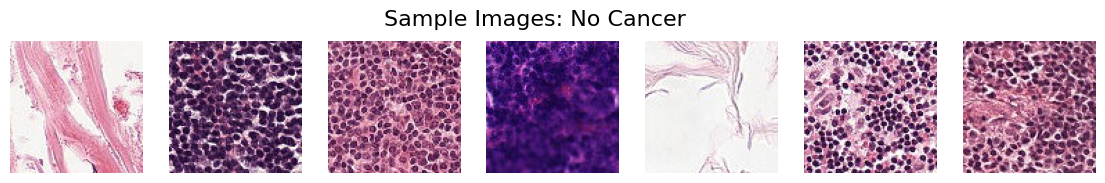

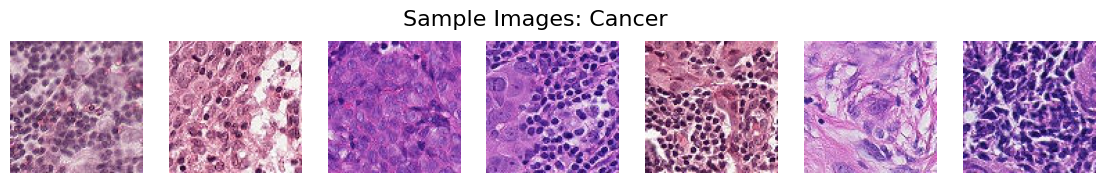

In [5]:
def show_samples(label, num_samples=7):
    """
    Displays sample images for a given label.

    Parameters:
    - label (int): The label to filter images (0: No Cancer, 1: Cancer)
    - num_samples (int): Number of sample images to display
    """
    # Mapping from numeric labels to descriptive strings
    label_mapping = {0: 'No Cancer', 1: 'Cancer'}
    label_name = label_mapping.get(label, 'Unknown')  # Get the descriptive label name

    # Get a random sample of images with the specified label
    sample_images = labels[labels['label'] == label].sample(n=num_samples, random_state=42)
    plt.figure(figsize=(14, 2))

    for i, img_name in enumerate(sample_images['id']):
        img_path = os.path.join(train_images_dir, img_name + '.tif')  # Construct the image path
        img = Image.open(img_path)  # Open the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(f'Sample Images: {label_name}', fontsize=16)
    plt.show()

# Show samples for 'No Cancer' and 'Cancer'
show_samples(label=0, num_samples=7)  # No Cancer
show_samples(label=1, num_samples=7)  # Cancer


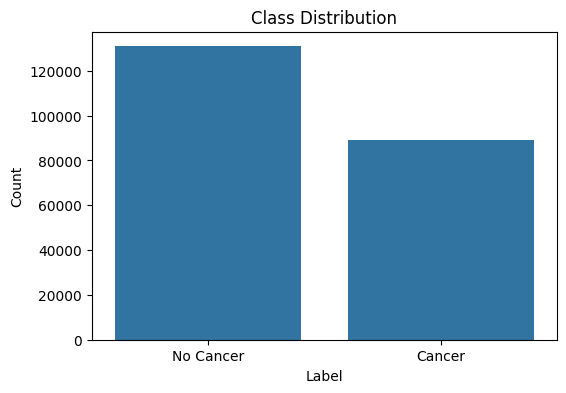

In [6]:
# Countplot of the labels
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=labels)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1], ['No Cancer', 'Cancer'])
plt.show()


In [7]:
# Check for missing values
print("Missing Values in Labels:")
print(labels.isnull().sum())


Missing Values in Labels:
id       0
label    0
dtype: int64


In [8]:
# Total number of images
num_train_images = len(os.listdir(train_images_dir))
print(f'Total training images: {num_train_images}')

# Define sampling fractions
sampling_fraction = 0.01  # 1% of the data

# Separate labels based on classes
subset_0 = labels[labels['label'] == 0].sample(frac=sampling_fraction, random_state=42)
subset_1 = labels[labels['label'] == 1].sample(frac=sampling_fraction, random_state=42)

# Split each subset into training and validation
train_0, val_0 = train_test_split(subset_0, test_size=0.2, random_state=42)
train_1, val_1 = train_test_split(subset_1, test_size=0.2, random_state=42)

# Combine and shuffle the training and validation sets
train_labels = pd.concat([train_0, train_1]).sample(frac=1, random_state=42).reset_index(drop=True)
val_labels = pd.concat([val_0, val_1]).sample(frac=1, random_state=42).reset_index(drop=True)

# Convert labels to string (optional, depending on ImageDataGenerator needs)
train_labels['label'] = train_labels['label'].astype(str)
val_labels['label'] = val_labels['label'].astype(str)

# Add filename column
train_labels['filename'] = train_labels['id'] + '.tif'
val_labels['filename'] = val_labels['id'] + '.tif'

# Display the distribution after sampling
print("Training Labels Distribution after Sampling:")
print(train_labels['label'].value_counts())


Total training images: 220025
Training Labels Distribution after Sampling:
label
0    1047
1     712
Name: count, dtype: int64


In [9]:
# Define ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,    # Randomly flip images vertically
    rotation_range=20,     # Randomly rotate images by 20 degrees
    zoom_range=0.15,       # Randomly zoom images
    width_shift_range=0.2, # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.15,      # Shear intensity
    fill_mode='nearest'    # Fill mode for new pixels
)

# Validation data should not be augmented, only rescaled
val_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
# Flow images from dataframe for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_images_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

# Flow images from dataframe for validation
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_images_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)


Found 1759 validated image filenames belonging to 2 classes.
Found 441 validated image filenames belonging to 2 classes.


In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Sequential

def create_baseline_model():
    """
    Creates a baseline CNN model.
    """
    model = Sequential([
        Input(shape=(96, 96, 3)),  # Input layer with specified input shape
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

baseline_model = create_baseline_model()
baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def create_advanced_model():
    """
    Creates an advanced CNN model with more layers and dropout for regularization.
    """
    model = Sequential([
        Input(shape=(96, 96, 3)),  # Input layer with specified input shape
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

advanced_model = create_advanced_model()
advanced_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile Baseline Model
baseline_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Compile Advanced Model
advanced_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
# Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [16]:
# Train the Baseline Model
history_baseline = baseline_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.5537 - loss: 1.2236 - val_accuracy: 0.6168 - val_loss: 0.6163 - learning_rate: 0.0010
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.6408 - loss: 0.6357 - val_accuracy: 0.6803 - val_loss: 0.5776 - learning_rate: 0.0010
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.7043 - loss: 0.5971 - val_accuracy: 0.7098 - val_loss: 0.6213 - learning_rate: 0.0010
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.7464 - loss: 0.5269 - val_accuracy: 0.6825 - val_loss: 0.6974 - learning_rate: 0.0010
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.7653 - loss: 0.4857 - val_accuracy: 0.7823 - val_loss: 0.5555 - learning_rate: 0.0010
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - a

In [19]:
# Restart the kernel and re-import libraries before proceeding

# Re-import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Re-define the Advanced Model
def create_advanced_model():
    model = Sequential([
        Input(shape=(96, 96, 3)),  # Input layer with specified input shape
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate the model
advanced_model = create_advanced_model()

# Define a new optimizer instance
optimizer_advanced = Adam(learning_rate=0.0001)

# Compile the model with the new optimizer
advanced_model.compile(optimizer=optimizer_advanced, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history_advanced = advanced_model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 0.5750 - loss: 0.7088 - val_accuracy: 0.5941 - val_loss: 0.6765 - learning_rate: 1.0000e-04
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.6019 - loss: 0.6648 - val_accuracy: 0.7483 - val_loss: 0.6693 - learning_rate: 1.0000e-04
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.6344 - loss: 0.6376 - val_accuracy: 0.5737 - val_loss: 0.6638 - learning_rate: 1.0000e-04
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.6833 - loss: 0.5896 - val_accuracy: 0.6145 - val_loss: 0.6235 - learning_rate: 1.0000e-04
Epoch 8/20

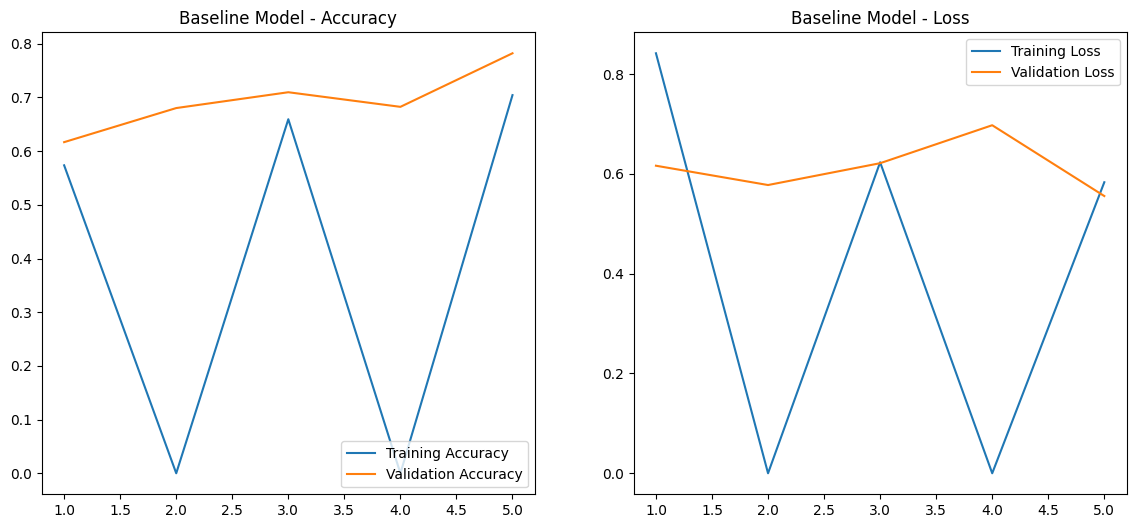

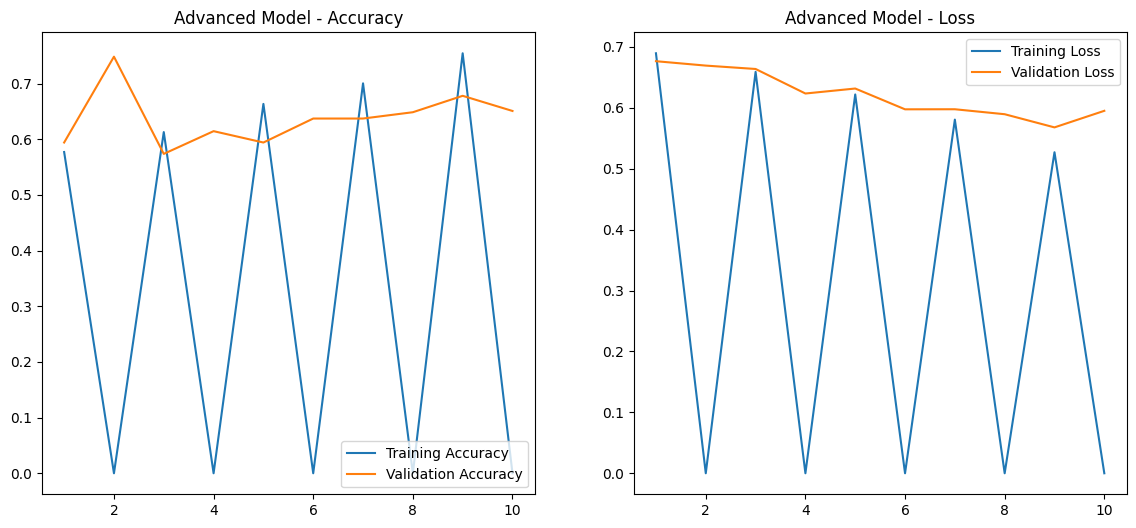

In [21]:
def plot_history(history, title):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: Keras History object
    - title: Title for the plots
    """
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])

    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    # Determine the minimum number of epochs recorded
    min_epochs = min(len(acc), len(val_acc), len(loss), len(val_loss))

    if min_epochs == 0:
        print("No data available to plot.")
        return

    epochs_range = range(1, min_epochs + 1)

    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc[:min_epochs], label='Training Accuracy')
    plt.plot(epochs_range, val_acc[:min_epochs], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss[:min_epochs], label='Training Loss')
    plt.plot(epochs_range, val_loss[:min_epochs], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')

    plt.show()

# Plot Baseline Model History
plot_history(history_baseline, 'Baseline Model')

# Plot Advanced Model History
plot_history(history_advanced, 'Advanced Model')


In [22]:
# Evaluate the Advanced Model on Validation Data
val_loss, val_accuracy = advanced_model.evaluate(val_generator, steps=len(val_generator))
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6863 - loss: 0.5642
Validation Loss: 0.5679
Validation Accuracy: 0.6780


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step


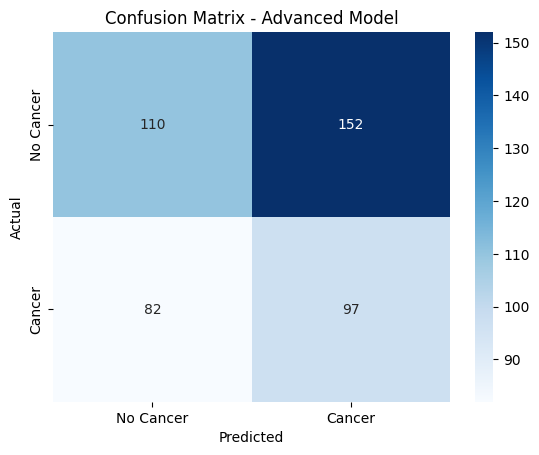

Classification Report:
              precision    recall  f1-score   support

   No Cancer       0.57      0.42      0.48       262
      Cancer       0.39      0.54      0.45       179

    accuracy                           0.47       441
   macro avg       0.48      0.48      0.47       441
weighted avg       0.50      0.47      0.47       441



In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on Validation Data
val_predictions = advanced_model.predict(val_generator, steps=len(val_generator))
val_predictions_binary = (val_predictions > 0.5).astype(int).reshape(-1)

# Get true labels
val_true = val_labels['label'].astype(int).values

# Confusion Matrix
cm = confusion_matrix(val_true, val_predictions_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Advanced Model')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(val_true, val_predictions_binary, target_names=['No Cancer', 'Cancer']))


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
ROC AUC Score: 0.4523


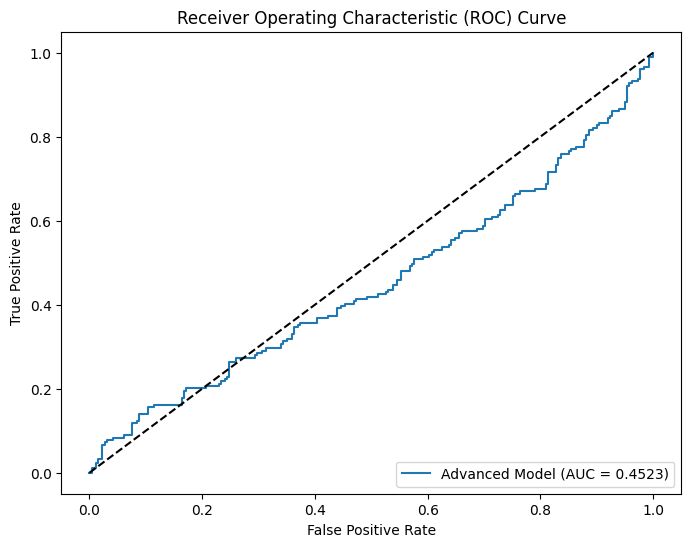

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC AUC
y_pred_prob = advanced_model.predict(val_generator, steps=len(val_generator)).reshape(-1)
roc_auc = roc_auc_score(val_true, y_pred_prob)
print(f'ROC AUC Score: {roc_auc:.4f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(val_true, y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Advanced Model (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [25]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [26]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(96, 96, 3)))

    # Tune the number of Conv2D layers
    for i in range(hp.Int('conv_layers', 2, 4)):
        model.add(Conv2D(
            filters=hp.Choice(f'filters_{i}', [32, 64, 128]),
            kernel_size=(3,3),
            activation='relu'
        ))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    model.add(Flatten())

    # Tune the number of Dense layers and units
    for i in range(hp.Int('dense_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
            activation='relu'
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_dense_{i}', 0.1, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [27]:
# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='histopathologic_cancer_detection'
)


In [28]:
# Early Stopping callback
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search
tuner.search(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[stop_early]
)


Trial 30 Complete [00h 01m 25s]
val_accuracy: 0.5941042900085449

Best val_accuracy So Far: 0.795918345451355
Total elapsed time: 00h 23m 52s


In [29]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of Conv2D layers is {best_hps.get('conv_layers')},
the optimal number of filters in the first Conv2D layer is {best_hps.get('filters_0')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of Conv2D layers is 3,
the optimal number of filters in the first Conv2D layer is 64,
and the optimal learning rate for the optimizer is 0.001.



In [30]:
# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)

history_tuned = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 0.5745 - loss: 0.7407 - val_accuracy: 0.5941 - val_loss: 0.6560 - learning_rate: 0.0010
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.5913 - loss: 0.6424 - val_accuracy: 0.6190 - val_loss: 0.6609 - learning_rate: 0.0010
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.6898 - loss: 0.5852 - val_accuracy: 0.6259 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.6950 - loss: 0.6096 - val_accuracy: 0.7029 - val_loss: 0.6164 - learning_rate: 0.0010
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.7744 - loss: 0.5256 - val_accuracy: 0.7052 - val_loss: 0.6032 - learning_rate: 0.0010


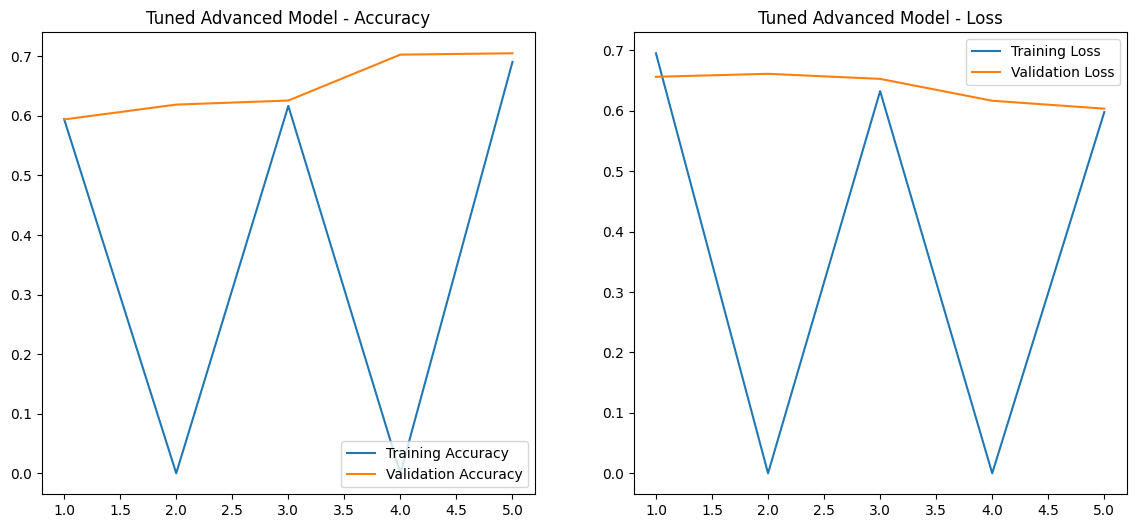

In [31]:
# Plot Tuned Model History
plot_history(history_tuned, 'Tuned Advanced Model')


In [32]:
# Load test data
test_ids = os.listdir(test_images_dir)
test_ids = [id_.replace('.tif', '') for id_ in test_ids]

# Create a DataFrame for test images
test_df = pd.DataFrame({
    'id': test_ids,
    'filename': [f"{id_}.tif" for id_ in test_ids]
})

# Display first few rows
print("Test DataFrame:")
display(test_df.head())


Test DataFrame:


,id,filename
0,0e6c087a2a1553d39ed7b21cb21b94cc2694e7ac,0e6c087a2a1553d39ed7b21cb21b94cc2694e7ac.tif
1,99e79639b2a5190b4900e8429c8531cf6c228544,99e79639b2a5190b4900e8429c8531cf6c228544.tif
2,956d4e65991c2f89454bd3299219b5b8853bd829,956d4e65991c2f89454bd3299219b5b8853bd829.tif
3,79683f284e0c45da863952867dfc74dfef238d2d,79683f284e0c45da863952867dfc74dfef238d2d.tif
4,72cb7385cf8d80d3ee65a9d37892fb9fe0de042f,72cb7385cf8d80d3ee65a9d37892fb9fe0de042f.tif


In [33]:
# Define ImageDataGenerator for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_images_dir,
    x_col='filename',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)


Found 57458 validated image filenames.


In [35]:
# Make predictions with the Advanced Model
print("Making predictions on test data with Advanced Model...")
test_predictions_advanced = advanced_model.predict(test_generator, steps=len(test_generator), verbose=1)
test_predictions_advanced = test_predictions_advanced.flatten()

# Alternatively, make predictions with the Tuned Model
test_predictions_tuned = model.predict(test_generator, steps=len(test_generator), verbose=1)
test_predictions_tuned = test_predictions_tuned.flatten()


Making predictions on test data with Advanced Model...
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step


In [36]:
# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': test_predictions_advanced
})

# Ensure no missing values
print("Missing Values in Submission:")
print(submission.isnull().sum())

# Display first few rows
print("Sample Submission:")
display(submission.head())


Missing Values in Submission:
id       0
label    0
dtype: int64
Sample Submission:


,id,label
0,0e6c087a2a1553d39ed7b21cb21b94cc2694e7ac,0.174783
1,99e79639b2a5190b4900e8429c8531cf6c228544,0.504957
2,956d4e65991c2f89454bd3299219b5b8853bd829,0.445574
3,79683f284e0c45da863952867dfc74dfef238d2d,0.052429
4,72cb7385cf8d80d3ee65a9d37892fb9fe0de042f,0.133012


In [37]:
# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")


Submission file 'submission.csv' created successfully.
